该笔记本旨在根据包含大约 5000 部电影和电视剧的 TMDB 数据集的内容构建一个推荐引擎。基本上，该引擎的工作原理如下：在用户提供他喜欢的电影的名称后，该引擎应该 能够在数据库中选择用户喜欢的 5 部电影列表。 在实践中，推荐引擎分为三种：

- **基于流行度的**引擎：通常是最容易实现也是最客观的
- **基于内容**引擎：建议基于产品描述
- **协同过滤**引擎：来自不同用户的记录根据用户相似性提供推荐

在当前情况下，由于数据集仅描述电影和电视剧的内容，因此排除了协同过滤，因此我将构建一个同时使用条目内容和受欢迎程度的引擎。

___

本笔记本的结构如下：

**1. 探索数据**

- 1.1 关键词
- 1.2 填充因子：缺失值
- 1.3 每年电影数量
- 1.4 流派

**2. 数据清洗**

- 2.1 关键词的清理
   * 2.1.1 按根分组
   * 2.1.2 同义词组
- 2.2 相关性
- 2.3 缺失值
   * 2.3.1 设置缺失的所有权年份
   * 2.3.2 从标题中提取关键词
   * 2.3.3 回归估算

**3. 推荐引擎**

- 3.1 引擎的基本功能
   * 3.1.1 相似性
   * 3.1.2 流行度
- 3.2 推荐引擎功能定义
- 3.3 提出有意义的建议
- 3.4 推荐示例：测试用例



___
## 1.探索

  首先，我们定义一些函数来创建具有数据集新结构的接口。
  下面的代码完全取自[Sohier的内核](https://www.kaggle.com/sohier/film-recommendation-engine-converted-to-use-tmdb)：

In [2]:
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    '''
    load_tmdb_movies() 函数从 CSV 文件中加载 TMDB 电影数据。它将 release_date 列转换为 datetime 对象，
    然后 genres、keywords、production_countries、production_companies 和 spoken_languages 列中的每个 JSON 字符串转换为 Python 列表。
    '''
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    '''
    load_tmdb_credits() 函数从 CSV 文件中加载 TMDB 信用数据。它将 cast 和 crew 列中的每个 JSON 字符串转换为 Python 列表。
    '''
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________

def safe_access(container, index_values):
    '''
    safe_access() 是一个辅助函数，它返回列表或字典中指定索引处的值，如果索引超出范围，则返回 NaN。
'''
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    '''
    get_director() 函数返回电影的导演的名字。它将一个演员列表作为输入，并返回第一个演员的名字，其工作名称为 Director。
    '''
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    '''
    pipe_flatten_names() 函数将列表列表转换为字符串，其中包含列表中的所有名称，每个名称用管道字符 (|) 分隔。
    '''
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):

    '''convert_to_original_format() 函数将 TMDB 电影数据和 TMDB 信用数据合并在一起，并将其转换为 IMDB 格式。
    它首先将 TMDB 电影数据的列名重命名为 IMDB 数据集中的列名。然后，它添加一个新的列 title_year，其中包含电影上映的年份。
    它还假设 production_countries 列中的第一个生产国家是电影制作的国家，并添加一个新的列 country，其中包含该信息。
    它还添加了新的列 language、director_name、actor_1_name、actor_2_name 和 actor_3_name，其中包含有关电影导演、演员和女演员的信息
    最后，它使用 pipe_flatten_names() 函数将 genres 和 plot_keywords 列从列表列表转换为字符串。
'''
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________


In [4]:
# load the dataset
credits = load_tmdb_credits("archive/tmdb_5000_credits.csv")
movies = load_tmdb_movies("archive/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0.0,0.0,64.355611,0.0,0.0,1.790548,0.0,0.062461,0.0,0.0,0.0,0.02082,0.0,0.041641,0.0,0.0,17.572351,0.0,0.0,0.0,0.02082,3.622736,0.62461,1.103477,1.31168,1.93629


In [81]:
df_initial

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,Action|Crime|Thriller,NaN,9367,united states–mexico barrier|legs|arms|paper k...,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2040920,81.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992.0,Mexico,Robert Rodriguez,Jaime de Hoyos,Peter Marquardt,Reinol Martinez
4799,9000,Comedy|Romance,NaN,72766,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,2011.0,NaN,Edward Burns,Kerry Bishé,Marsha Dietlein,Caitlin Fitzgerald
4800,0,Comedy|Drama|Romance|TV Movie,http

___
### 1.1 Keywords

为了开发推荐引擎，我计划广泛使用描述电影的关键词。 事实上，一个基本的假设是，相似关键词描述的电影应该有相似的内容。 因此，我计划仔细研究关键字的定义方式，作为第一步，我快速描述其中已有的内容。 为此，我首先列出数据集中的关键字：

In [5]:
# 将电影数据集中的所有关键字合并到一个集合中。
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

# 删除空字符
set_keywords.remove('')

In [6]:
set_keywords

{'ocean liner',
 'board',
 'sex doll',
 'troubled production',
 'canada',
 'toaster',
 'gestapo',
 'prison escape',
 'israel',
 'record',
 'platonic love',
 'teacher student relationship',
 'kompliment',
 'irresistible',
 'mind transfer',
 'black panther',
 'submerged',
 'amateur detective',
 'music contest',
 'secession',
 'alien infection',
 'photo shoot',
 'soccer coach',
 'space war',
 'keks',
 'infertility',
 'jellybean',
 'ransom',
 'punishment',
 'star crossed lovers',
 'saturday night live',
 'dark',
 'rolling a cigarette',
 'slovakia',
 'anonymous letter',
 'destiny',
 'movie studio',
 'civil rights activist',
 'october',
 'underwear',
 'outsourcing',
 'last chance',
 'taiwanese',
 'american football star',
 'quitting a job',
 'checkpoint',
 'woman',
 'electric guitar',
 'small town murder',
 'catholic guilt',
 'intimidation',
 'child pornography',
 'bitten in the neck',
 'franco regime',
 'nationalism',
 'slavery',
 'western spoof',
 'temperature drop',
 'search for dog',
 'f

定义一个函数来计算它们关键字出现的次数:

In [7]:
def count_word(df, ref_col, liste):
    """
    统计列表中所有词语出现的频率。

    参数：
        df：包含要统计词频的 DataFrame 对象。
        ref_col：要统计词频的列名。
        liste：要统计的词语列表。

    返回：
        一个列表，其中包含按词语出现的频率排序的词语元组。
    """
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    # 遍历 df[ref_col] 列，并统计每个字符串中词语的出现频率。
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # 将 keyword_count 字典转换为一个列表，并按词语出现的频率进行排序。
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [8]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

在此阶段，关键字列表已创建，我们知道每个关键字在数据集中出现的次数。 其实可以通过这个榜单来感受一下“最受欢迎的电影”的内容。 提供该信息的一种奇特方式是使用 *wordcloud* 包。 在这种表示中，所有单词都排列在一个图形中，其大小取决于它们各自的频率。 我们可以使用直方图来代替词云来提供相同的信息。 这允许得到一个图形，其中关键字按出现次数排序，最重要的是，这给出了它们出现的次数，这是无法从词云表示中检索的信息。 在下图中，我比较了两种类型的表示形式：

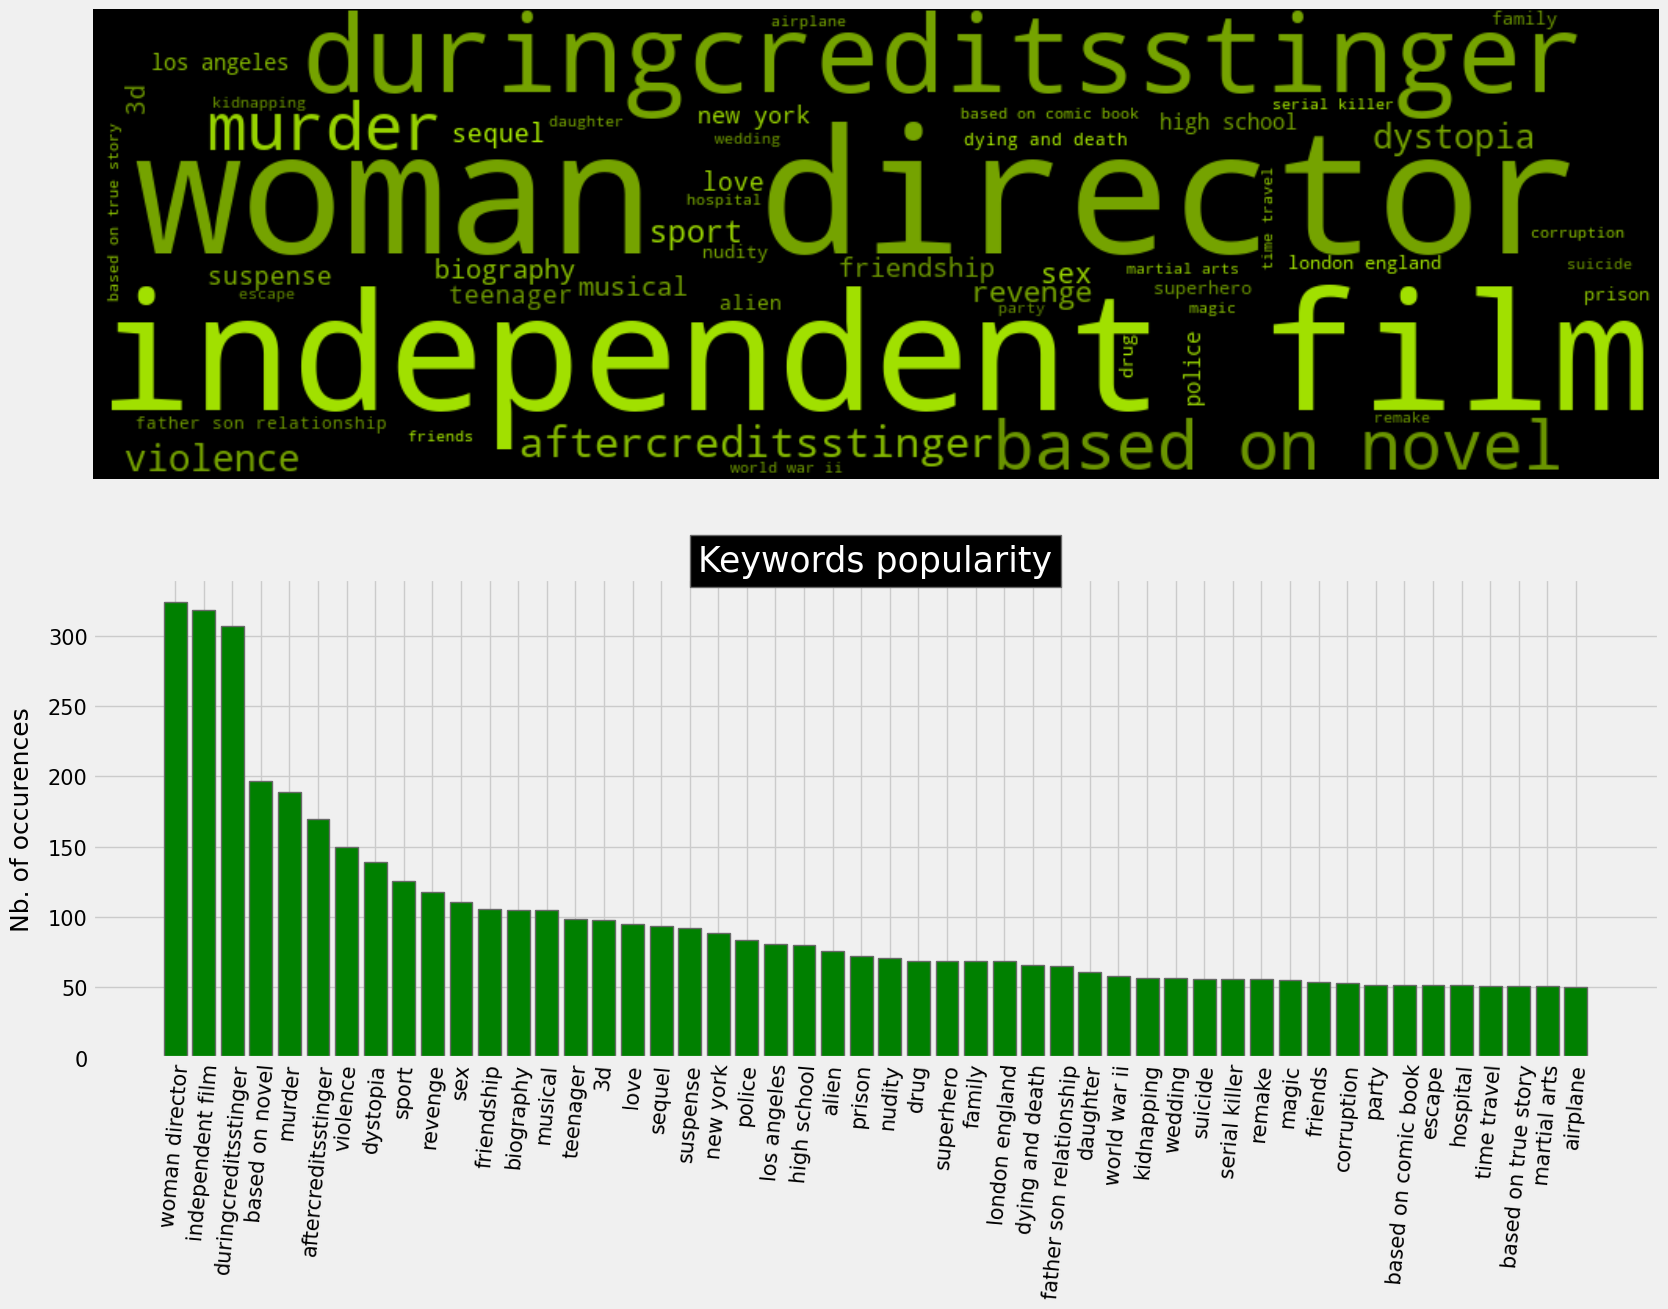

In [9]:
#_____________________________________________
# Function that control the color of the words
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# WARNING: the scope of variables is used to get the value of the "tone" variable
# I could not find the way to pass it as a parameter of "random_color_func()"
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    """
    生成随机的颜色。

    参数：
        word：当前词语的名称。
        font_size：当前词语的字体大小。
        random_state：一个随机数生成器。

    返回：
        一个 16 进制颜色值。
    """

    # 计算随机的色调值、饱和度值和亮度值。
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words

## 使用 WordCloud 库生成词云图。
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

___
### 1.2 填充因子：缺失值

该数据集包含 5043 部电影或电视剧，由 28 个变量描述。 与每次分析一样，在某些时候，我们必须处理缺失值，作为第一步，我确定每个变量中缺失的数据量：

In [10]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


___
### 1.3 年份处理

**title_year** 变量表示电影的发行时间。 为了在全球范围内了解电影根据该变量的分布方式，我将电影按几十年进行分组：

In [11]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# 从grouby对象中提取统计参数的函数
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# 创建一个每十年统计信息的数据框架;
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

用饼状图表示结果:

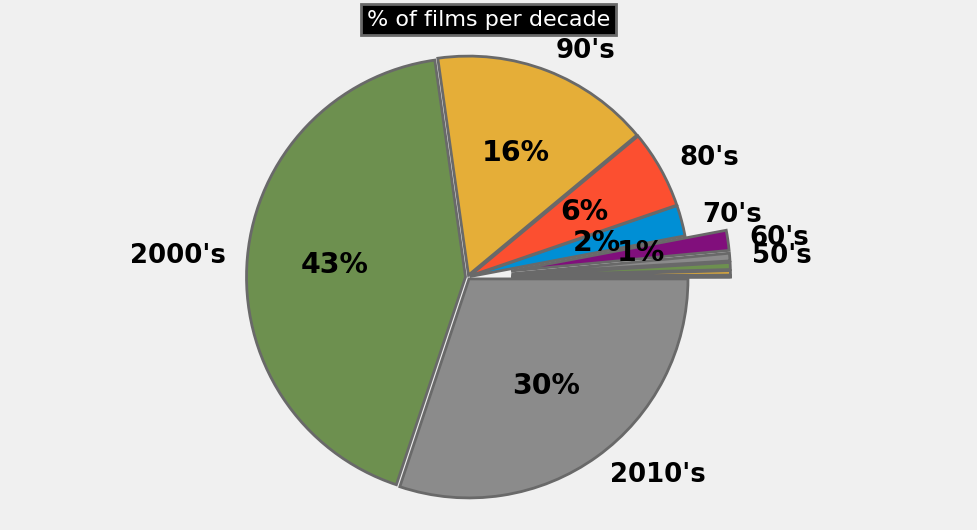

In [12]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    """
    设置图例的标签。

    参数：
        s：需要设置的标签。

    返回：
        格式化后的标签。
    """
    
    # 将年份转换为年代。
    val = (1900 + s, s)[s < 100]

    # 如果年代是 1900 到 1949 年，则不显示标签。
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

___
### 1.4 电影流派

**流派**变量在构建推荐引擎时肯定很重要，因为它描述了电影的内容（即戏剧、喜剧、动作……）。 为了准确了解哪些流派最受欢迎，我使用与关键字相同的方法（因此使用类似的代码行），首先对流派进行普查：

In [13]:
# 定义一个空集合 genre_labels，用于存储所有类型。
genre_labels = set()
# 遍历 `df_initial['genres']` 列，并将每个字符串用 `'|'` 分割成单个类型
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [14]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

结果显示为一个词云:

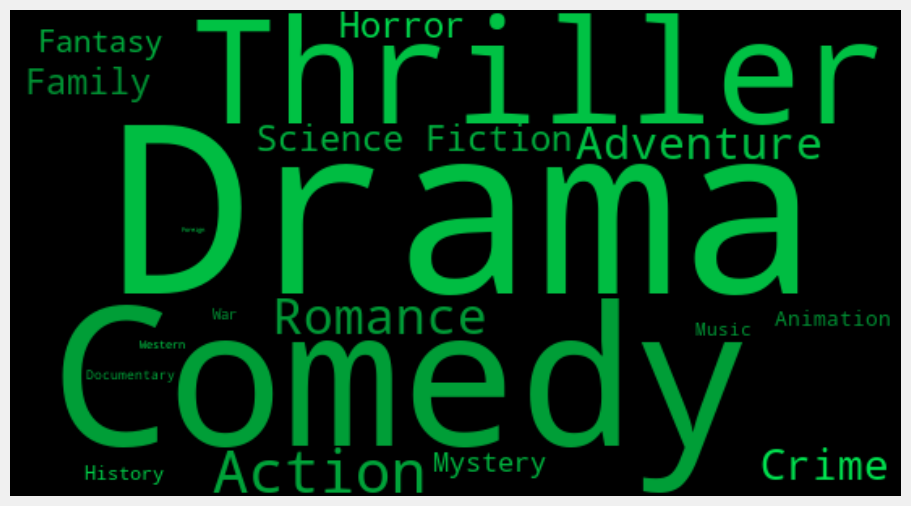

In [15]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
## 2. 数据清洗
___

In [16]:
df_duplicate_cleaned = df_initial

___
### 2.1 关键词的清理

关键字将在引擎的运行中发挥重要作用。 事实上，推荐将基于电影之间的相似性，为了衡量这种相似性，我将寻找由相同关键词描述的电影。 因此， **plot_keywords** 变量的内容值得关注，因为它将被广泛使用。


___
#### 2.1.1 按*根*分组

我收集 **plot\_keywords** 变量中出现的关键字。 然后使用 NLTK 包清理该列表。 最后，我查找各个关键字出现的次数。

In [17]:
# Collect the keywords
#----------------------
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    """
    收集关键词

    参数：
        dataframe：包含要收集关键词的 DataFrame 对象。
        colonne：要收集关键词的列名。

    返回：
        一个由关键词组成的列表，以及一个由关键词根和关键词组成的字典。
    """

    PS = nltk.stem.PorterStemmer()  #  词干提取器oll
    keywords_roots  = dict()  # 收集词根/词
    keywords_select = dict()  # 根 <-> 词 的映射
    category_keys = []        # 关键词列表
    icount = 0
    # 遍历 DataFrame 对象 `dataframe` 中的列 `colonne`。
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        # 将字符串 `s` 分割为单个词，并将每个词的词根添加到字典 `keywords_roots` 中
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t) # 将所有词转换为小写。 提取词根。
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)   # 如果词根已经存在，则将该词添加到该词根的列表中。
            else:
                keywords_roots[racine] = {t}   # 否则，创建一个新的列表并将该词添加到该列表中。
    
    # 遍历字典 `keywords_roots` 中的所有词根。
    for s in keywords_roots.keys():
        # 如果该词根对应的词的数量大于 1，则选择长度最短的词作为该词根对应的关键词。
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)       # 选择长度最短的词。      
            category_keys.append(clef)
            keywords_select[s] = clef
        # 否则，将该词根对应的第一个词作为该词根对应的关键词。
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [18]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 9474


In [19]:
keywords_select

{'culture clash': 'culture clash',
 'futur': 'future',
 'space war': 'space war',
 'space coloni': 'space colony',
 'societi': 'society',
 'space travel': 'space travel',
 'futurist': 'futuristic',
 'romanc': 'romance',
 'space': 'space',
 'alien': 'alien',
 'tribe': 'tribe',
 'alien planet': 'alien planet',
 'cgi': 'cgi',
 'marin': 'marine',
 'soldier': 'soldier',
 'battl': 'battle',
 'love affair': 'love affair',
 'anti war': 'anti war',
 'power rel': 'power relations',
 'mind and soul': 'mind and soul',
 '3d': '3d',
 'ocean': 'ocean',
 'drug abus': 'drug abuse',
 'exotic island': 'exotic island',
 'east india trading compani': 'east india trading company',
 "love of one's lif": "love of one's life",
 'traitor': 'traitor',
 'shipwreck': 'shipwreck',
 'strong woman': 'strong woman',
 'ship': 'ship',
 'allianc': 'alliance',
 'calypso': 'calypso',
 'afterlif': 'afterlife',
 'fighter': 'fighter',
 'pirat': 'pirate',
 'swashbuckl': 'swashbuckler',
 'aftercreditssting': 'aftercreditsstinge

In [20]:
# Plot of a sample of keywords that appear in close varieties 
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alienation', 'alien'} 2
2 {'spying', 'spy'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terror', 'terrorism'} 2
5 {'flooding', 'flood'} 2
6 {'spider', 'spiders'} 2
7 {'horses', 'horse'} 2
8 {'music', 'musical'} 2
9 {'anime', 'animation', 'animal'} 3
10 {'compassion', 'compass'} 2
11 {'train', 'training'} 2
12 {'sail', 'sailing'} 2
13 {'time traveler', 'time travel'} 2
14 {'orc', 'orcs'} 2


In [21]:
# Replacement of the keywords by the main form
#----------------------------------------------
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    """
    用主要形式替换关键词

    参数：
        df：包含要替换关键词的 DataFrame 对象。
        dico_remplacement：关键词到主要形式的映射字典。
        roots：如果为 True，则使用词根进行替换。

    返回：
        一个新的 DataFrame 对象，其中关键词已被替换。
    """
    df_new = df.copy(deep = True)   # 创建一个新的 DataFrame 对象，并将其复制自 `df`。
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']   # 获取当前行的 `plot_keywords` 列的值。
        if pd.isnull(chaine): continue

        # 将字符串 `chaine` 分割为单个词。
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            # 如果 `roots` 为 True，则使用词根进行替换。
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                # 否则，将原始词添加到列表 `nouvelle_liste`。
                nouvelle_liste.append(s)   
        # 将列表 `nouvelle_liste` 设置为当前行的 `plot_keywords` 列的值。    
        # df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste)) 
        df_new.loc[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new

In [22]:
# 用主密钥字替换密钥字
#-------------------------------------------------
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)

In [23]:
# Count of the keywords occurences
#----------------------------------
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

___
#### 2.2.2 *同义词*组

我分两步清理关键字列表。 第一步，我会抑制出现次数少于 5 次的关键字，并用频率更高的同义词替换它们。 第二步，我抑制出现在少于 3 部电影中的所有关键字

In [24]:
# 此函数可以用于获取关键词的丰富语义信息。例如，如果关键词是 "love"，那么程序可以返回以下同义词：
# ['love', 'affection', 'attachment', 'fondness', 'liking', 'passion', 'attachment', 'partiality', 'prepossession', 'preference']
# 这些同义词可以帮助我们更好地理解关键词的含义。
def get_synonymes(mot_cle):
    """
    获取关键词的同义词

    参数：
        mot_cle：关键词。

    返回：
        关键词的同义词集合。
    """
    lemma = set()  # 同义词集合
    # 从 WordNet 中获取关键词的同义词集合。
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
           # 只获取名词的同义词。
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [25]:
# Exemple of a list of synonyms given by NLTK
#---------------------------------------------------
#初次使用nltk，需要使用 nltk.download() 函数来下载 wordnet 资源。
# import nltk
# nltk.download('wordnet')

mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\77463\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 "foreigner                     " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "unknown                       " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0
 "alien                         " in keywords list -> True 80
 "extraterrestrial              " in keywords list -> True 4
 "noncitizen                    " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0


In [26]:
# check if 'mot' is a key of 'key_count' with a test on the number of occurences   
#----------------------------------------------------------------------------------
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [27]:
# 对关键词的出现次数进行排序，按出现次数降序排列
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
# 创建一个字典，其中键是关键词，值是该关键词的出现次数
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# 定义一个字典，用于存储要替换的关键词和它们的替换词
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # 跳过出现次数大于 5 的关键词
    # 获取关键词的所有同义词
    lemma = get_synonymes(mot)
     # 跳过没有同义词的关键词
    if len(lemma) == 0: continue     
    #_________________________________________________________________
    # 创建一个列表，其中包含关键词的同义词和它们在字典 `key_count` 中的值
    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    # 对列表 `liste_mots` 进行排序，按同义词的出现次数降序排列
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue        # 跳过没有同义词的关键词
    if mot == liste_mots[0][0]: continue     # 跳过替换为自身的关键词
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    # 将第一个同义词添加到字典 `remplacement_mot`
    remplacement_mot[mot] = liste_mots[0][0]

# 打印替换了多少个关键词（以百分比表示）
print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.99% of the keywords.


In [28]:
# 2 successive replacements
#---------------------------
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]                    

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [29]:
# replacement of keyword varieties by the main keyword
#----------------------------------------------------------
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8908


In [30]:
# New count of keyword occurences
#-------------------------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [31]:
# deletion of keywords with low frequencies
#-------------------------------------------
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    """
    用主要形式替换关键词

    参数：
        df：包含要替换关键词的 DataFrame 对象。
        keyword_occurences：列表，其中每个元素是一个元组，元组的第一个元素是关键词，第二个元素是关键词的出现次数。

    返回：
        一个新的 DataFrame 对象，其中关键词已被替换。
    """
    # 创建一个新的 DataFrame 对象，并将其复制自 `df`。
    df_new = df.copy(deep = True)

    # 创建一个字典，其中键是关键词，值是该关键词的出现次数。
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]  

    # 遍历 DataFrame 对象 `df_new` 中的所有行。  
    for index, row in df_new.iterrows():
        # 获取当前行的 `plot_keywords` 列的值。
        chaine = row['plot_keywords']
        # 如果该值为空，则跳过。
        if pd.isnull(chaine): continue
        # 将字符串 `chaine` 分割为单个词。
        nouvelle_liste = []
        for s in chaine.split('|'): 
            # 如果该词在字典 `key_count` 中，且其出现次数大于 3，则将其添加到列表 `nouvelle_liste`。
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        # 将列表 `nouvelle_liste` 设置为当前行的 `plot_keywords` 列的值。
        df_new.loc[index, 'plot_keywords'] =  '|'.join(nouvelle_liste)
    return df_new

In [32]:
# Creation of a dataframe where keywords of low frequencies are suppressed
#-------------------------------------------------------------------------
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')    

Nb of keywords in variable 'plot_keywords': 2120


In [33]:
# New keywords count
#-------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

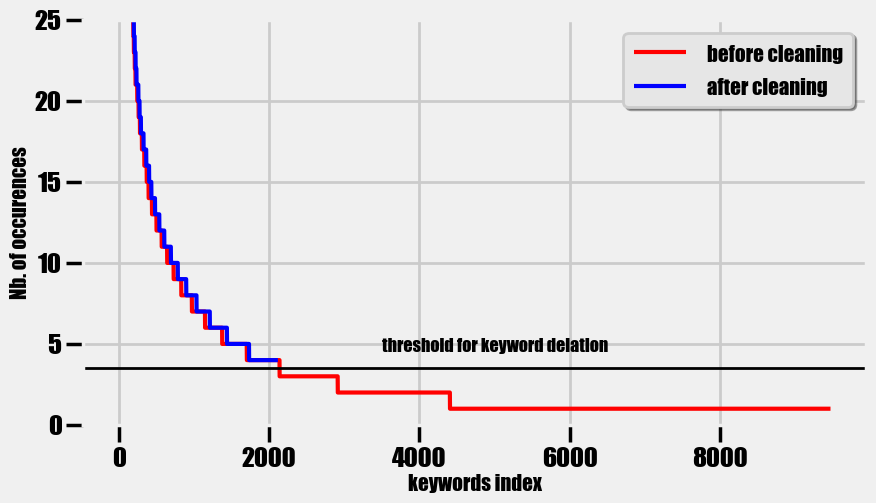

In [34]:
# 绘制关键词出现次数的图形
#----------------------------
# 设置字体格式
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

# 对关键词出现次数进行排序，按出现次数降序排列
keyword_occurences.sort(key = lambda x:x[1], reverse = True)

# 获取关键词出现次数的列表
y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

# 获取清洗后关键词出现次数的列表
new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
# 在图形上绘制两条线，分别表示清洗前和清洗后的关键词出现次数
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
# 在图形上添加一条水平线，表示关键词删除阈值
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()

___
### 2.2 相关性

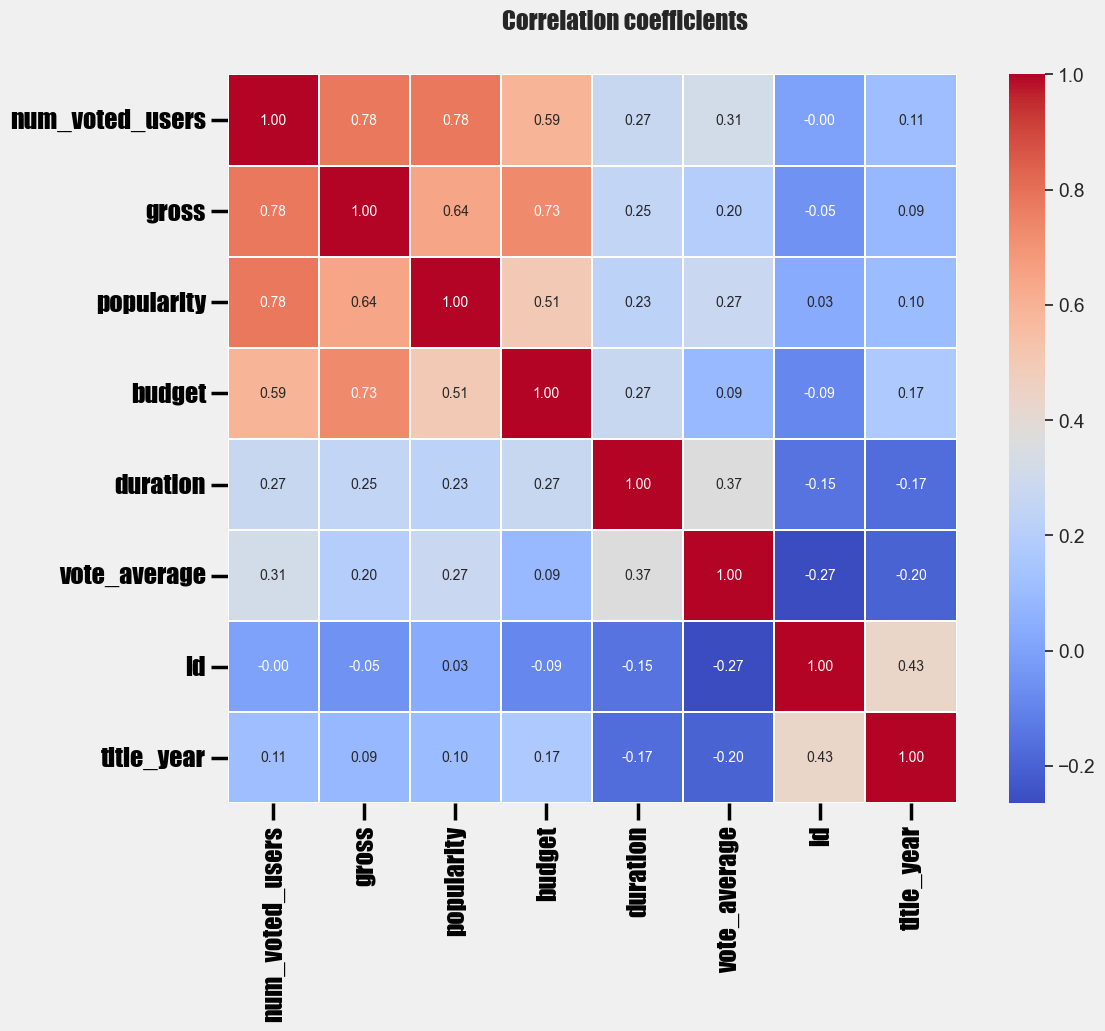

In [35]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

根据上面报告的值，我从数据框中删除了一些变量，然后对列重新排序。

In [36]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

___
### 2.3 缺失值
我检查每个变量中缺失值的数量，然后选择一种方法来完成数据集.

In [37]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


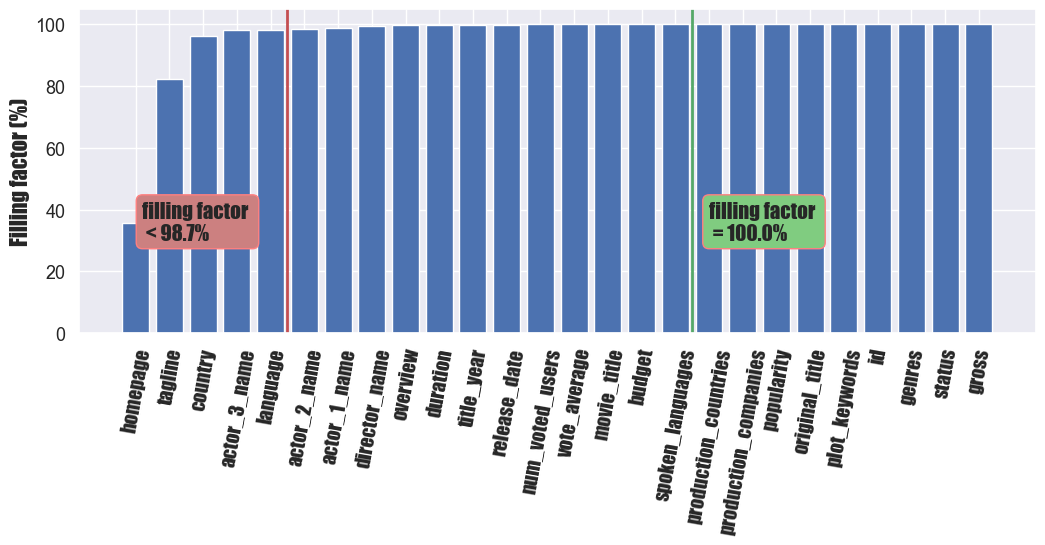

In [38]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

___
#### 2.3.1 设置缺失的头衔年份

  为了推断标题年份，我使用了演员和导演名单。 对于每个人，我使用当前数据集确定平均活动年份。 然后我对获得的值进行平均以估计标题年份。

In [39]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [40]:
df_filling.iloc[4553]

budget                                                                  0
genres                                                                   
homepage                                                              NaN
id                                                                 380097
plot_keywords                                                            
language                                                              NaN
original_title                                 America Is Still the Place
overview                1971 post civil rights San Francisco seemed li...
popularity                                                            0.0
production_companies                                                   []
production_countries                                                   []
release_date                                                          NaT
gross                                                                   0
duration                              

In [41]:
def fill_year(df):
    """
    该函数用于填充缺失的电影年份。

    参数：
        df：包含电影信息的数据框。

    返回：
        df：填充缺失值后的数据框。
    """

    # 定义需要用到的变量。
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']  # 演员和导演的列名
    usual_year = [0 for _ in range(4)]   # 存储每列的平均年份
    var        = [0 for _ in range(4)]   # 存储临时变量
    #_____________________________________________________________
 # 计算每列的平均年份。
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    #_____________________________________________
   # 创建一个字典，存储每个演员和导演的平均年份。
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
    #______________________________________
    # 查找缺失电影年份的信息。
    missing_year_info = df[df['title_year'].isnull()]
    #___________________________
    # # 填充缺失值。
    icount_replaced = 0   # 记录填充了多少个缺失值
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]   # 存储每个演员和导演的名字
        icount = 0 ; sum_year = 0  # 记录有效值的个数 , 存储有效值的总和
        for i in range(4):            
            var[i] = df.loc[index][col[i]]   # 获取第i个演员或导演的名字
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]  # 将第i个演员或导演的平均年份存储到value中
        if icount != 0: sum_year = sum_year / icount    # 计算平均年份

        if int(sum_year) > 0:   # 只填充非负值
            icount_replaced += 1
            df.loc[index, 'title_year'] = int(sum_year)  # 将平均年份填充到缺失值所在的单元格
            if icount_replaced < 10: 
                print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return df

In [42]:
fill_year(df_filling)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space colony|society|spac...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|british...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,Action|Crime|Thriller,NaN,9367,united states–mexico barrier|stagecoach|weapon,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2040920,81.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992.0,Mexico,Robert Rodriguez,Jaime de Hoyos,Peter Marquardt,Reinol Martinez
4799,9000,Comedy|Romance,NaN,72766,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,2011.0,NaN,Edward Burns,Kerry Bishé,Marsha Dietlein,Caitlin Fitzgerald
4800,0,Comedy|Drama|Romance|TV Movie,http://

___
#### 2.3.2 从标题中提取关键词

如前所述，关键字将在引擎的功能中发挥重要作用。 因此，我尝试使用标题的单词填充 **plot_keywords** 变量中的缺失值。 为此，我创建标题中包含的所有单词的同义词列表，并检查这些同义词中是否已存在于关键字列表中。 在这种情况下，我会将此关键字添加到条目中：

In [43]:
icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    liste_mot = row['movie_title'].strip().split()
    new_keyword = []
    for s in liste_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.loc[index, 'plot_keywords'] = '|'.join(new_keyword)

#### 2.3.3 从回归中估算

在第 2.4 节中，我查看了变量之间的相关性，发现其中一些变量表现出一定程度的相关性，皮尔逊系数 > 0.5：

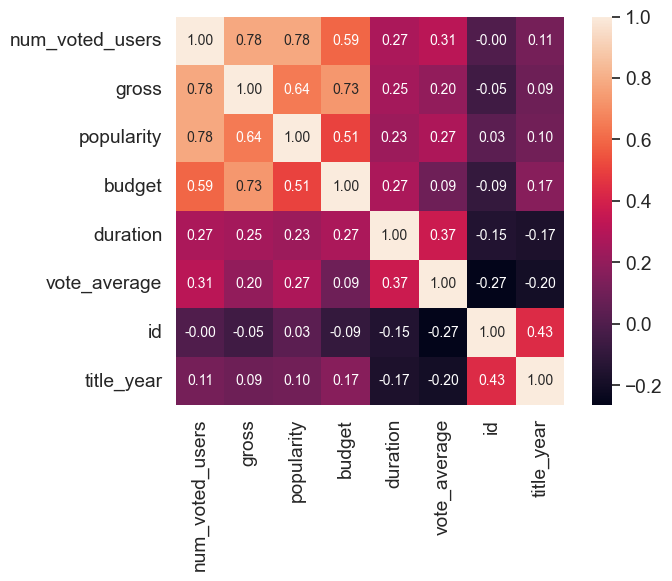

In [44]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

我将使用这一发现来填充 **gross**、**num_critic_for_reviews**、**num\_voted\_users** 和 **num_user_for_reviews** 变量的缺失值。 为此，我将对相关变量对进行回归：

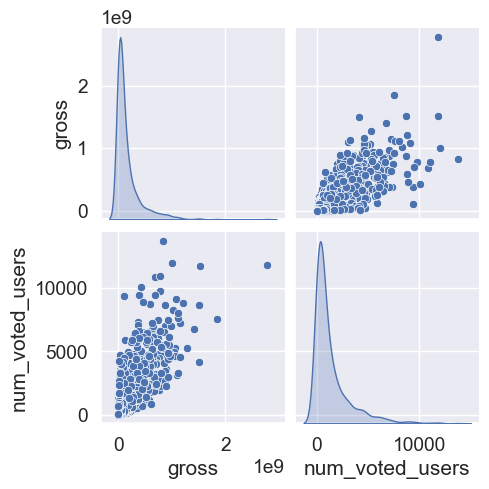

In [64]:
sns.set(font_scale=1.25)
cols = ['gross', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

首先，我定义一个函数，根据数据的线性拟合估算缺失值：

In [46]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    """
    该函数用于使用线性回归进行变量插补。

    参数：
        df：包含数据的数据框。
        col_to_predict：需要插补的变量名。
        ref_col：用于插补的参考变量名。

    返回：
        df：插补后的数据框。
    """
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.loc[index, col_to_predict] =  value

该函数将数据帧以及两列的名称作为输入。 在这两列之间执行线性拟合，用于填充给定的第一列中的空：

In [47]:
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')

最后，我检查数据框中仍然缺少哪些数据量：

In [48]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


我们可以看到，在最坏的情况下，填充因子约为 96%（不包括 **homepage** 和 **tagline** 变量）。

In [49]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

In [50]:
df

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space colony|society|spac...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|british...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,Action|Crime|Thriller,NaN,9367,united states–mexico barrier|stagecoach|weapon,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2040920,81.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,1992.0,Mexico,Robert Rodriguez,Jaime de Hoyos,Peter Marquardt,Reinol Martinez
4799,9000,Comedy|Romance,NaN,72766,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,2011.0,NaN,Edward Burns,Kerry Bishé,Marsha Dietlein,Caitlin Fitzgerald
4800,0,Comedy|Drama|Romance|TV Movie,http://

___
## 3. 推荐引擎---基于内容和受欢迎程度

___
### 3.1 引擎的基本功能
  为了构建推荐引擎，我基本上会分两步进行：
- 1/ 确定$N$个与用户提供的条目内容相似的电影
- 2/ 从这些$N$电影中选择5部最受欢迎的电影

#### 3.1.1 相似性
因此，在构建引擎时，第一步就是定义一个标准，告诉我们两部电影有多接近。 为此，我从用户选择的电影的描述开始：从中获取导演姓名、演员姓名和一些关键词。 然后，我构建一个矩阵，其中每一行对应于数据库中的一部电影，其中各列对应于先前的数量（导演 + 演员 + 关键字）加上第 1.4 节中描述的 *k* 类型：

|  movie title |director   |actor 1   |actor 2   |actor 3   | keyword 1  | keyword 2   | genre 1 | genre 2 | ... | genre k |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Film 1   | $a_{11}$  |  $a_{12}$ |   |   |  ... |   |   |   |   | $a_{1q}$  |
|...   |   |   |   |   | ...  |   |   |   |   |   |
|Film i   |  $a_{i1}$ | $a_{i2}$ |   |   | $a_{ij}$  |   |   |   |   |  $a_{iq}$ |
|...   |   |   |   |   | ...  |   |   |   |   |   |
| Film p   |$a_{p1}$   | $a_{p2}$  |   |   | ...  |   |   |   |   | $a_{pq}$  |

在此矩阵中，$a_{ij}$ 系数取值 0 或 1，具体取决于列 $j$ 的重要性与电影 $i$ 的内容之间的对应关系。 例如，如果“关键字 1”在电影 $i$ 中，则 $a_{ij}$ = 1，否则为 0。 一旦定义了这个矩阵，我们就可以根据以下公式确定两部电影之间的距离：

\begin{align}
d_{m, n} = \sqrt{ \sum_{i = 1}^{N} \left( a_{m,i} - a_{n,i} \right)^2 }
\end{align}

在此阶段，我们只需选择与用户选择的条目最接近的 N 部电影即可。

#### 3.1.2 流行度

根据条目之间的相似性，我们得到了 $N$ 电影的列表。 在这个阶段，我从这个列表中选择了 5 部电影，为此，我为每部影片打分。 我决定根据 3 个标准计算分数：
- IMDB 评分
- 条目收到的票数
- 发行年份

前两个标准将直接衡量 IMDB 中各个条目的受欢迎程度。 对于第三个标准，我介绍了发行年份，因为数据库涵盖了从 $XX^{th}$  世纪初至今的电影。 我认为人们最喜欢的电影大多来自同一时代。

然后，我根据以下公式计算分数：


\begin{align}
\mathrm{score} = IMDB^2 \times \phi_{\sigma_1, c_1} \times  \phi_{\sigma_2, c_2}
\end{align}

 $\phi$ is 高斯函数:

\begin{align}
\phi_{\sigma, c}(x) \propto \mathrm{exp}\left(-\frac{(x-c)^2}{2 \, \sigma^2}\right)
\end{align}

对于投票，我在 $N$ 部电影中获得最大票数，并设置 $\sigma_1 = c_1 = m$。 多年来，我设置 $\sigma_1 = 20$ 并将高斯集中在用户选择的电影的标题年份上。 对于高斯函数，我更加重视具有大量票数的条目以及发行年份与用户选择的标题接近的电影。

___
### 3.2 引擎功能定义

In [65]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

**收集一些变量内容的函数**： *entry\_variables()* 函数返回变量 *'director\_name', 'actor\_N\_name'* (N $\in$ [1: 3]) 和 *'plot\_keywords'* 用于用户选择的电影。

In [66]:
def entry_variables(df, id_entry): 
    """
    该函数用于获取指定数据框中指定条目中所有变量名。

    参数：
        df：包含数据的数据框。
        id_entry：指定条目的索引。

    返回：
        col_labels：所有变量名列表。
    """
    # 定义变量。
    col_labels = []  
    # 获取导演名字列表。  
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)

    # 获取演员名字列表。        
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)

    # 获取剧情关键词列表。            
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

**向数据帧添加变量的函数**：函数 *add\_variables()* 将变量列表添加到输入中给定的数据帧，并根据与电影和描述的对应关系将这些变量初始化为 0 或 1 输入中给出的 REF_VAR 变量的内容。

In [67]:
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in row[categorie].split('|'):
                if s in REF_VAR: df.loc[index, s] =  1            
    return df

**创建电影列表的函数**：*recommended()* 函数创建一个包含 N (= 31) 部与用户选择的电影相似的电影的列表。

In [68]:
def recommand(df, id_entry):
    """
    该函数用于为指定数据框中指定条目推荐电影。

    参数：
        df：包含数据的数据框。
        id_entry：指定条目的索引。

    返回：
        indices：推荐的电影的索引列表。
    """
    # 定义变量。    
    df_copy = df.copy(deep = True)    
    liste_genres = set()   # 集合，用于存储所有电影类型。
    # 获取所有电影类型。
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    
    #_____________________________________________________
    # 创建额外的变量来检查相似度。
    variables = entry_variables(df_copy, id_entry)  # 调用 entry_variables() 函数，获取指定条目中的所有变量名。
    variables += list(liste_genres)   # 将 liste_genres 中的所有电影类型添加到 variables 列表中。
    df_new = add_variables(df_copy, variables)   # 调用 add_variables() 函数，根据 variables 列表添加新变量到 df_copy 数据框中。
    #____________________________________________________________________________________
    # 计算最近邻：根据新变量计算距离。
    X = df_new[variables].values   # 将 df_new[variables] 列表的值转换为 NumPy 数组。
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)   # 创建一个最近邻算法模型，设置参数 n_neighbors=31，表示计算相似度最高的 31 个邻居。

    distances, indices = nbrs.kneighbors(X)      # 使用 kneighbors() 方法计算相似度和邻居索引。
    xtest = df_new.iloc[id_entry][variables].values
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]
    

**给电影打分的函数**：*critere\_selection()* 函数根据电影的 IMDB 评分、标题年份和为该电影投票的用户数量给电影打分。

In [69]:
def critere_selection(title_main, max_users, annee_ref, titre, annee, imdb_score, votes):   
    """
    该函数用于计算推荐电影的评分。

    参数：
        title_main：主电影的标题。
        max_users：最大投票用户数。
        annee_ref：主电影的年份。
        titre：推荐电影的标题。
        annee：推荐电影的年份。
        imdb_score：推荐电影的评分。
        votes：推荐电影的投票用户数。

    返回：
        note：推荐电影的评分。
    """
    # 判断主电影是否有年份。 
    if pd.notnull(annee_ref):
        # 计算年份相似度。
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        # 如果主电影没有年份，则年份相似度为 1。
        facteur_1 = 1        

    # 计算投票用户数相似度。
    sigma = max_users * 1.0    # 定义一个标准差 sigma，用于计算投票用户数相似度。

    if pd.notnull(votes):  # 如果推荐电影有投票用户数，则使用高斯滤波来计算投票用户数相似度。
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:  # 如果推荐电影没有投票用户数，则投票用户数相似度为 0。
        facteur_2 = 0
        
    # 判断推荐电影是否是主电影的续集。
    if sequel(title_main, titre):
        # 如果是续集，则评分为 0。
        note = 0
    else:
        # 如果不是续集，则评分为评分、年份相似度和投票用户数相似度的乘积
        note = imdb_score**2 * facteur_1 * facteur_2
    
    return note

**从电影列表中提取一些参数的函数**：*create\_film\_selection()* 函数提取输入中给定的数据帧的一些变量，并返回此列表以选择 N 部电影。 该列表根据 *critere\_selection()* 函数中建立的标准进行排序。

In [84]:
def extract_parameters(df, liste_films):  
    """
    该函数用于从推荐的电影列表中提取相关参数。

    参数：
        df：包含数据的数据框。
        liste_films：推荐的电影列表。

    返回：
        parametres_films：包含相关参数的列表。
    """
    # 定义变量。
    parametres_films = ['_' for _ in range(31)]  # parametres_films 是一个列表，用于存储相关参数。
    i = 0    # i 是一个计数器，用于遍历推荐的电影列表。
    max_users = -1   # max_users 是一个变量，用于保存最大投票用户数。
    for index in liste_films:
        # 将电影的相关参数存储到列表中。
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'vote_average', 'popularity', 
                                        'num_voted_users']])
        parametres_films[i].append(index)
        # 更新最大投票用户数。
        max_users = max(max_users, parametres_films[i][4] )
        i += 1

    # 获取主电影的标题和年份。    
    title_main = parametres_films[0][0]
    annee_ref  = parametres_films[0][1]
    # 按照评分、年份和投票用户数进行排序。
    parametres_films.sort(key = lambda x:critere_selection(title_main, max_users,
                                    annee_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parametres_films 

**比较 2 个电影标题的函数**：续集 *sequel()* 函数比较输入中传递的 2 个标题，并定义这些标题是否相似。

In [71]:
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

**添加电影的函数**：*add\_to\_selection()* 函数完成*film\_selection* 列表，其中包含将推荐给用户的 5 部电影。 这些电影是从 *parameters\_films* 列表中选择的，并且仅当标题与其他电影标题足够不同时才会被考虑。

In [72]:
def add_to_selection(film_selection, parametres_films): 
    """
    该函数用于将推荐的电影添加到推荐列表中。

    参数：
        film_selection：推荐列表。
        parametres_films：推荐的电影列表。

    返回：
        film_selection：更新后的推荐列表。
    """
    # 定义变量。   
    film_list = film_selection[:]  # film_list 是推荐列表的副本。
    icount = len(film_list)   # icount 是推荐列表的长度。 
    for i in range(31):
        # 遍历推荐的电影列表。
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: already_in_list = True  # 如果电影已在推荐列表中，则设置 already_in_list 为 True。
            if sequel(parametres_films[i][0], s[0]): already_in_list = True   #如果电影是推荐电影的续集，则设置 already_in_list 为 True。      
        if already_in_list: continue    # 如果电影已在推荐列表中或是推荐电影的续集，则跳过。
        # 如果电影未在推荐列表中，则添加到列表中。
        icount += 1
        # 如果电影未在推荐列表中，则将电影添加到列表中。
        if icount <= 5:
            film_list.append(parametres_films[i])   
    return film_list

**函数过滤续集**：如果存在两部以上的系列电影，*remove\_sequels()* 函数将从列表中删除续集。 旧的保留了下来。

In [73]:
def remove_sequels(film_selection):    
    """
    该函数用于从推荐列表中删除续集。

    参数：
        film_selection：推荐列表。

    返回：
        film_selection：更新后的推荐列表。
    """
    removed_from_selection = []   # removed_from_selection 是存储删除的电影的列表。
    # 遍历推荐列表。
    for i, film_1 in enumerate(film_selection):
        # 遍历推荐列表，从第 i+1 个开始。
        for j, film_2 in enumerate(film_selection):
            # 如果 j 小于 i，则跳过。
            if j <= i: continue 
            # 如果 film_1 是 film_2 的续集，则将 film_2 从推荐列表中删除。
            if sequel(film_1[0], film_2[0]): 
                # 如果 film_1 是 film_2 的续集，则将 film_2 从推荐列表中删除并添加到 removed_from_selection 列表中。
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    # 从推荐列表中删除续集。
    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list   

**主要功能**：创建将推荐给用户的 5 部影片的列表。

In [74]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):   
    '''
    df：包含电影数据的 DataFrame。
    id_entry：要推荐相似电影的电影 ID。
    del_sequels：是否删除推荐列表中的续集。默认为 True。
    verbose：是否打印详细信息。默认为 False。
    返回值：

    selection_titres：推荐电影的列表，每个电影由其标题和 IMDb 评分组成。
    '''
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    # 调用 recommand() 函数来获取与给定电影 ID 最相似的 30 部电影的 ID 列表。
    liste_films = recommand(df, id_entry)
    #__________________________________
    # Create a list of 31 films
    # 调用 extract_parameters() 函数来获取上述列表中每部电影的相关参数，包括电影标题、年份、评分、投票用户数和索引。
    parametres_films = extract_parameters(df, liste_films)
    #_______________________________________
    # Select 5 films from this list
    # 调用 add_to_selection() 函数将上述列表中前 5 部电影添加到 film_selection 列表中。
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    #__________________________________
    # delation of the sequels
    # 如果 del_sequels 为 True，则调用 remove_sequels() 函数从 film_selection 列表中删除续集。
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    # 调用 add_to_selection() 函数将上述列表中没有被添加到 film_selection 列表的电影添加到该列表中，但添加的电影数量不得超过 5 部。
    film_selection = add_to_selection(film_selection, parametres_films)
    #_____________________________________________
    selection_titres = []
    # 遍历 film_selection 列表，并将每个电影的标题和 IMDb 评分添加到 selection_titres 列表中。
    for i,s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titres

___
### 3.3 提出有意义的建议

在构建推荐引擎时，我们很快面临一个大问题：续集的存在使得某些推荐可能看起来相当愚蠢……举个例子，喜欢“加勒比海盗：聚魂棺”的人会 可能不喜欢被建议观看此内容：

In [85]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> The Lord of the Rings: The Fellowship of the Ring
nº2      -> X-Men: Days of Future Past    
nº3      -> The Hobbit: An Unexpected Journey
nº4      -> Thor                          
nº5      -> Thor: The Dark World          


不幸的是，如果我们根据第 3.1 节中描述的功能构建引擎，这就是我们被告知的！

这个问题的根源很容易理解：许多大片都有续集，它们的导演、演员和关键词都相同……大多数时候，续集存在的事实意味着它是“公平”的票房成功，这 是良好 IMDB 分数的同义词。 通常，续集之间存在成功的继承性，这意味着根据当前引擎的构建方式，很可能如果该引擎匹配一个系列的一部影片，那么它就会结束推荐多部影片。 在前面的例子中，我们看到引擎推荐了*《指环王》*三部曲的三部影片，以及*《雷神》*和*《雷神：黑暗世界》*。 好吧，我个人不会向朋友提出这样的建议......

因此，我试图找到一种方法来防止这种行为，我得出的结论是，最快的方法就是修改电影的标题。 为此，我使用 **fuzzywuzzy** 包来构建 *remove_sequels()* 函数。 该函数定义两个电影标题的相似程度，如果太接近，则从推荐列表中删除最新的电影。 在前面的示例中使用此函数，我们得出以下建议：

In [86]:
dum = find_similarities(df, 12, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> The Lord of the Rings: The Fellowship of the Ring
nº2      -> X-Men: Days of Future Past    
nº3      -> The Hobbit: An Unexpected Journey
nº4      -> Thor                          
nº5      -> The Amazing Spider-Man 2      


这似乎更合理！

但是，没有什么是完美的。 这种放弃一些推荐的方式假设与系列相关的电影的名称具有连续性。 然而情况并非总是如此：

In [ ]:
dum = find_similarities(df, 2, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=2 -> 'Spectre'
nº1      -> Spectre                       
nº2      -> Skyfall                       
nº3      -> Quantum of Solace             
nº4      -> The Art of War                
nº5      -> Kick-Ass 2                    


___
### 3.4 推荐示例：测试用例

In [87]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=0 -> 'Avatar'
nº1      -> Guardians of the Galaxy       
nº2      -> Captain America: The Winter Soldier
nº3      -> Edge of Tomorrow              
nº4      -> Star Trek                     
nº5      -> Thor                          
__________________________________________________________________________________________
QUERY: films similar to id=3 -> 'The Dark Knight Rises'
nº1      -> Batman Begins                 
nº2      -> Drive                         
nº3      -> Kick-Ass                      
nº4      -> The Equalizer                 
nº5      -> The Baader Meinhof Complex    
__________________________________________________________________________________________
QUERY: films similar to id=6 -> 'Tangled'
nº1      -> Inside Out                    
nº2      -> Spirited Away                 
nº3      -> Toy Story 3                   
nº4      -> Finding Nemo

___
## 4.推荐引擎--- scikit-surprise库实现

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset, Reader

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise import accuracy

### **奇异值分解（SVD）**
奇异值分解（SVD）是机器学习中矩阵分解方法之一。 奇异值分解将一个矩阵分解为另外三个矩阵，并从高级（用户-项目-评分）矩阵的分解中提取特征。
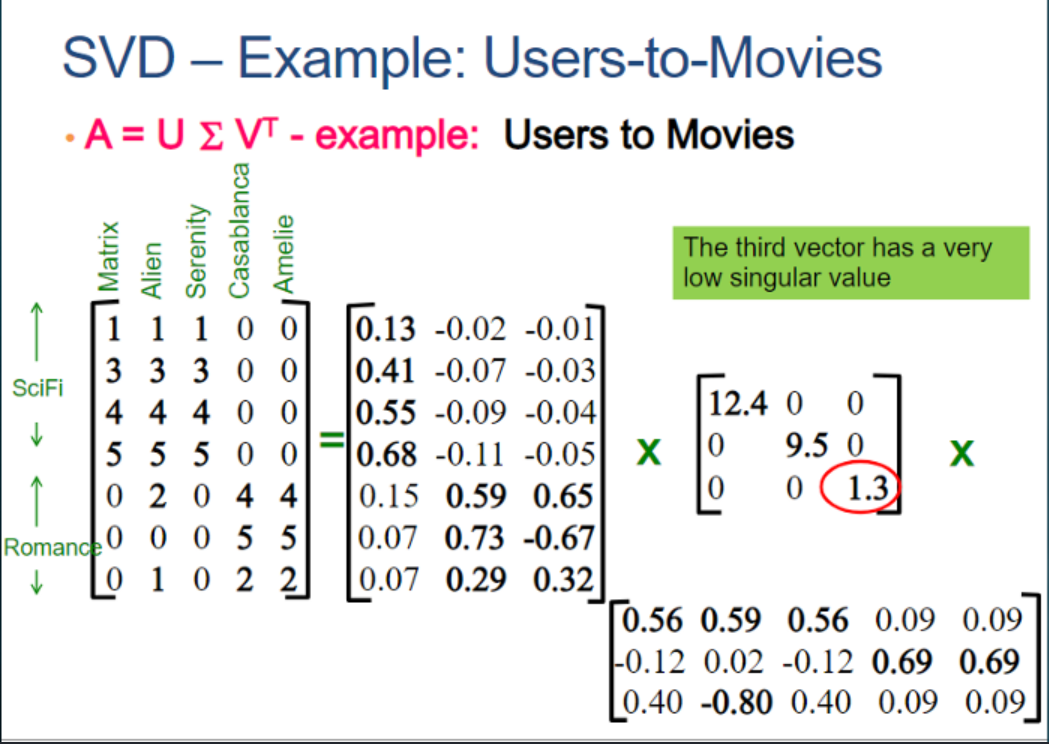
Where,

`Matrix U:` 用户的潜在特征

`Matrix S:` 表示每个特征强度的对角矩阵

`Matrix U:` 项目的潜在特征


In [ ]:
# 从电影数据集 movie_md 中提取电影 ID 和标题，并将票数限制为 55 次以上。
movie_md = movie_md[movie_md['vote_count']>55][['id','title']]

# IDs of movies with count more than 55
movie_ids = [int(x) for x in movie_md['id'].values]

# 从评分数据集 ratings 中选择包含在电影 ID 列表 movie_ids 中的评分。
ratings = ratings[ratings['movieId'].isin(movie_ids)]

# 重置评分数据集 ratings 的索引，并删除旧的索引列。
ratings.reset_index(inplace=True, drop=True)

ratings.head()

In [ ]:
# 初始化一个 surprise 的 Reader 对象。该对象用于将评分数据集转换为 surprise 可以理解的格式。
# 参数：
#   line_format：评分数据集的格式，默认为 'user item rating'
#   sep：评分数据集中用户、电影和评分的分隔符，默认为 ','
#   rating_scale：评分的范围，默认为 (0, 1)
#   skip_lines：跳过评分数据集前面的几行，默认为 0

reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# 从评分数据集 ratings 中加载数据。该语句会将评分数据集转换为 surprise 的 Dataset 对象。
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# 构建训练集对象 trainset。该语句会将数据集 data 的所有数据都用于训练。
trainset = data.build_full_trainset()

In [ ]:
# Initialize model
svd = SVD()

# cross-validate
svd.fit(trainset)

In [ ]:
svd.predict(uid=3,iid=2959,r_ui=5.0)

In [ ]:
svd.predict(uid=15,iid=2678,r_ui=1.0)

In [ ]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [ ]:
get_recommendations(data=ratings,movie_md=movie_md, user_id=654, top_n=10, algo=svd)

<a id='memory_based'></a>
## **基于内存的推荐系统**

基于记忆的方法使用用户评分历史数据来计算用户或项目之间的相似度。 这些方法背后的想法是定义用户或项目之间的相似性度量，并找到最相似的来推荐未见过的项目。
基于内存的推荐系统有两种类型 -

1. 基于用户

2. 基于项目

在基于用户的推荐方法中，我们将计算用户之间的相似度，并使用算法（KNN）获取最相似的用户，并将一个用户喜欢的电影推荐给另一个用户，反之亦然

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find similar items
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user.fit(trainset)

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=2,iid=17,r_ui=5.0)

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=671,iid=4011,r_ui=4.0)

In [ ]:
get_recommendations(ratings, movie_md, 671,10,sim_user)

<a id='item_based'></a>
### **基于项目**

在基于项目的推荐方法中，我们将计算项目（电影）之间的相似性，并使用算法（KNN）获取最相似的项目（电影），并将一个用户喜欢的项目（电影）推荐给喜欢类似类型的另一用户 项目（电影），反之亦然。


在建模部分，只有一个简单的区别，我们必须在初始化模型时将 sim_options 参数中的 user_based 设置为 False。

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find similar items
sim_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item.fit(trainset)

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=2,iid=17,r_ui=5.0)

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=671,iid=4011,r_ui=4.0)

In [ ]:
get_recommendations(ratings, movie_md, 671,10,sim_item)

___
## 5. 结论：可能的改进和需要解决的问题

最后，在构建引擎时没有考虑到一些事情，应该引起一些注意：
- 未检查电影的语言：事实上，这对于确保推荐的电影与用户选择的语言使用相同的语言可能很重要
- 另一点涉及用更频繁的同义词替换关键字。 在某些情况下，结果表明所选同义词与原始单词具有不同的含义。 当然，整个过程可能值得更多关注和改进。
- 另一个改进可能是创建演员之间的联系列表，以查看哪些演员曾经在类似的电影中扮演过角色
- 将续集的检测范围扩展到不具有相似标题的电影（例如詹姆斯·邦德系列）